In [1]:
# Facial Emotion Recognition: ANN vs. CNN

# Advanced project for classifying 7 emotions from face images using FER2013 dataset.
# - ANN: Baseline for comparison.
# - CNN: Main model with data augmentation for better performance.


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
from google.colab import files  # For image upload
import os

In [29]:
# Load and Preprocess FER2013 Data
# Download from Kaggle: https://www.kaggle.com/datasets/msambare/fer2013

In [3]:
!ls


archive.zip  sample_data


In [4]:
!unzip archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [5]:
# Paths
train_dir = 'train'
test_dir = 'test'

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical'
)

# For ANN: Need flattened data
def extract_data(generator):
    x, y = [], []
    for _ in range(generator.samples // 32):
        batch_x, batch_y = next(generator)
        x.extend(batch_x.reshape(batch_x.shape[0], -1))  # Flatten
        y.extend(batch_y)
    return np.array(x), np.array(y)

x_train_ann, y_train_ann = extract_data(train_generator)
x_val_ann, y_val_ann = extract_data(val_generator)
x_test_ann, y_test_ann = extract_data(test_generator)

print(f'Training samples: {train_generator.samples}')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Training samples: 22968


In [8]:
#Visualizing Samples

Found 22968 images belonging to 7 classes.


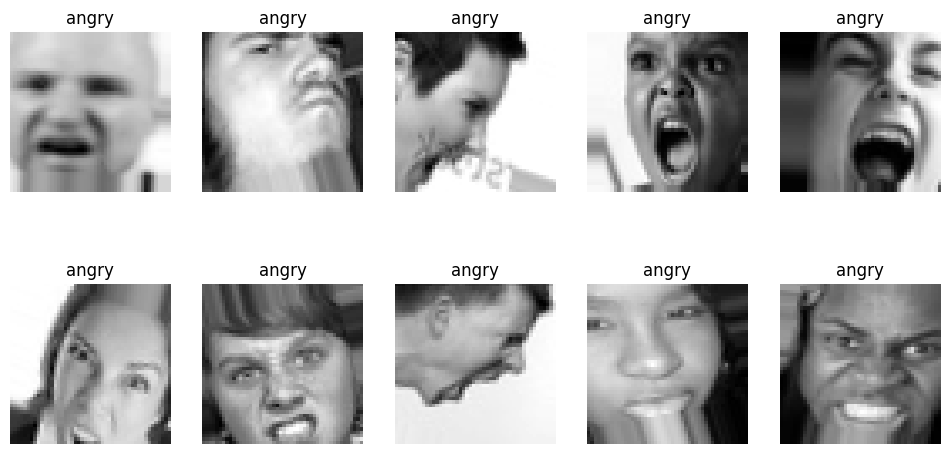

In [10]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


display_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=1,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training',
    shuffle=False
)

plt.figure(figsize=(12, 6))
for i in range(10):

    img_batch, label_batch = next(display_generator)
    plt.subplot(2, 5, i+1)

    plt.imshow(img_batch[0].squeeze(), cmap='gray')
    plt.title(emotions[np.argmax(label_batch[0])])
    plt.axis('off')
plt.show()

In [11]:
# Building and Training ANN Model (Baseline)

In [12]:
ann_model = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(48*48,)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ann_history = ann_model.fit(
    x_train_ann, y_train_ann,
    epochs=20,
    batch_size=32,
    validation_data=(x_val_ann, y_val_ann)
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2191 - loss: 1.9935 - val_accuracy: 0.2507 - val_loss: 1.8105
Epoch 2/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2506 - loss: 1.8112 - val_accuracy: 0.2507 - val_loss: 1.8102
Epoch 3/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2526 - loss: 1.8116 - val_accuracy: 0.2507 - val_loss: 1.8105
Epoch 4/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2507 - loss: 1.8115 - val_accuracy: 0.2507 - val_loss: 1.8100
Epoch 5/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2543 - loss: 1.8110 - val_accuracy: 0.2509 - val_loss: 1.8110
Epoch 6/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.2533 - loss: 1.8084 - val_accuracy: 0.2509 - val_loss: 1.8099
Epoch 7/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2510 - loss: 1.8137 - val_accuracy: 0.2509 - val_loss: 1.8101
Epoch 8/20
717/717 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.2493 - loss: 1.8116 - val_accuracy: 0

In [13]:
# Evaluating ANN

224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2442 - loss: 1.8152
ANN Test Accuracy: 0.2475
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


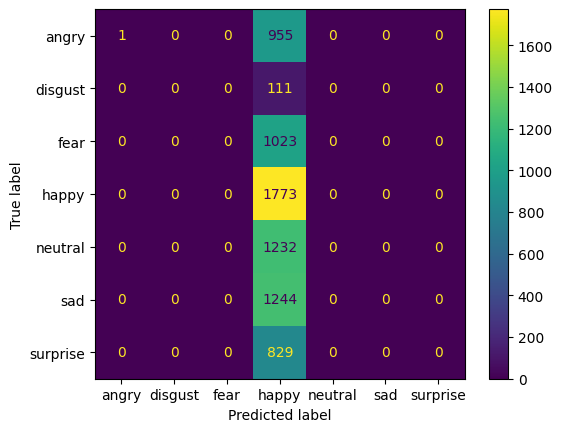

In [14]:
ann_test_loss, ann_test_acc = ann_model.evaluate(x_test_ann, y_test_ann)
print(f'ANN Test Accuracy: {ann_test_acc:.4f}')

ann_preds = np.argmax(ann_model.predict(x_test_ann), axis=1)
ann_cm = confusion_matrix(np.argmax(y_test_ann, axis=1), ann_preds)
ConfusionMatrixDisplay(ann_cm, display_labels=emotions).plot()
plt.show()

In [15]:
#Building and Training CNN Model (With Augmentation)

In [16]:
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 42s 46ms/step - accuracy: 0.2314 - loss: 1.8360 - val_accuracy: 0.2513 - val_loss: 1.7933
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.2557 - loss: 1.7928 - val_accuracy: 0.2735 - val_loss: 1.7565
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.2677 - loss: 1.7605 - val_accuracy: 0.2825 - val_loss: 1.7386
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.2831 - loss: 1.7410 - val_accuracy: 0.3168 - val_loss: 1.6877
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.3112 - loss: 1.6978 - val_accuracy: 0.3451 - val_loss: 1.6584
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.3482 - loss: 1.6432 - val_accuracy: 0.3820 - val_loss: 1.5770
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.3762 - loss: 1.5945 - val_accuracy: 0.4085 - val_loss: 1.5299
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.3980 - loss: 1.5430 - 

In [17]:
# Evaluating CNN

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5368 - loss: 1.2113
CNN Test Accuracy: 0.5410
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


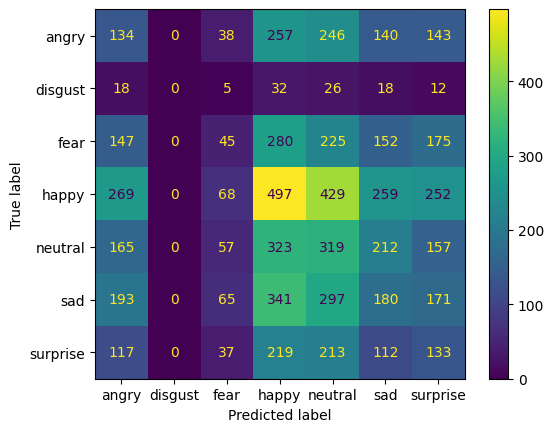

In [18]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(test_generator)
print(f'CNN Test Accuracy: {cnn_test_acc:.4f}')

# Reseting generator for predictions
test_generator.reset()
cnn_preds = np.argmax(cnn_model.predict(test_generator, steps=test_generator.samples // 32 + 1), axis=1)
true_labels = test_generator.classes[:len(cnn_preds)]
cnn_cm = confusion_matrix(true_labels, cnn_preds)
ConfusionMatrixDisplay(cnn_cm, display_labels=emotions).plot()
plt.show()

In [19]:
#Comparing ModeLs

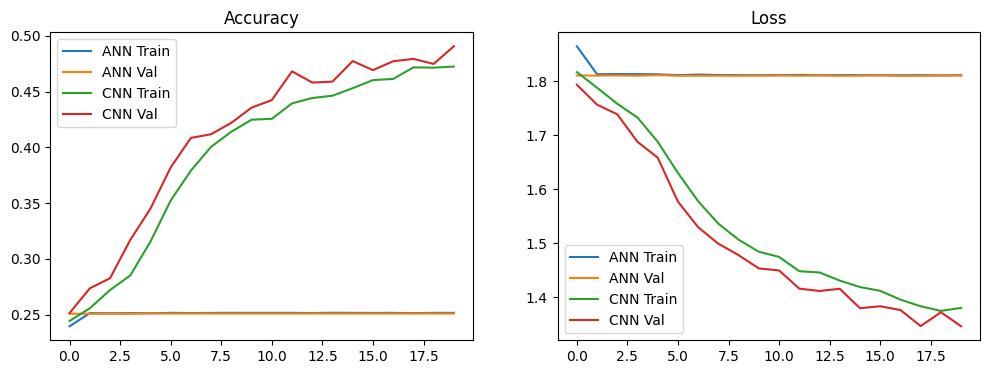

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(ann_history.history['accuracy'], label='ANN Train')
plt.plot(ann_history.history['val_accuracy'], label='ANN Val')
plt.plot(cnn_history.history['accuracy'], label='CNN Train')
plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ann_history.history['loss'], label='ANN Train')
plt.plot(ann_history.history['val_loss'], label='ANN Val')
plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.title('Loss')
plt.legend()
plt.show()

In [27]:
# Testing on Real Image

Saving test-image.jpg to test-image (1).jpg
Uploaded: test-image (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


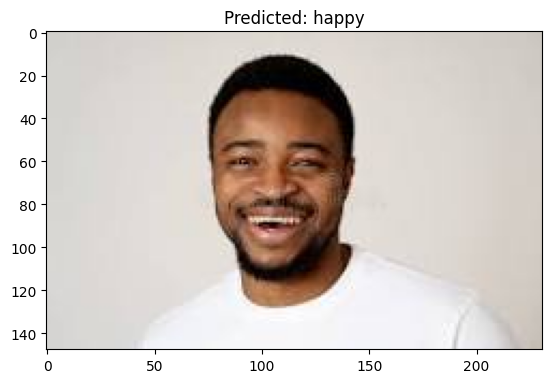

In [28]:
def predict_emotion(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (48, 48))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    return emotions[np.argmax(pred)]

# Upload image
uploaded = files.upload()
for fn in uploaded.keys():
    print(f'Uploaded: {fn}')
    emotion = predict_emotion(cnn_model, fn)
    img = plt.imread(fn)
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted: {emotion}')
    plt.show()